In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Installing YOLOR and other dependencies

In [ ]:
!git clone https://github.com/WongKinYiu/yolor
%cd yolor

# pip install required packages
!pip install -qr requirements.txt

# install mish-cuda if you want to use mish activation
# https://github.com/thomasbrandon/mish-cuda
# https://github.com/JunnYu/mish-cuda
!git clone https://github.com/JunnYu/mish-cuda
%cd mish-cuda
!python setup.py build install
%cd ..

# install pytorch_wavelets if you want to use dwt down-sampling module
# https://github.com/fbcotter/pytorch_wavelets
!git clone https://github.com/fbcotter/pytorch_wavelets
%cd pytorch_wavelets
!pip install .
%cd ..

In [ ]:
%cd ..

/content


Downloading dataset using RoboFlow

In [ ]:
!curl -L "https://app.roboflow.com/ds/SHCtBw9VBZ?key=d9g9CzpDnd" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

In [ ]:
# !curl -L "https://app.roboflow.com/ds/SkVKkLaqpn?key=f23Gpl9HMC" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

File name modification since yolo data loader interefered with existing names

In [ ]:
import os

def remove_stops(fold_path):


  for file in os.listdir(fold_path):
    src_path = os.path.join(fold_path,file)
    prefix, ext = file.rsplit('.',maxsplit=1)
    outfile = prefix.replace('.','_').replace('jpg','') + '.' + ext
    dst_path = os.path.join(fold_path,outfile)
    os.rename(src_path,dst_path)

remove_stops('/content/train/images')
remove_stops('/content/train/labels')
remove_stops('/content/valid/images')
remove_stops('/content/valid/labels')
remove_stops('/content/test/images')
remove_stops('/content/test/labels')

In [ ]:
img_files = os.listdir('/content/train/images/')
label_files = os.listdir('/content/train/labels/')

In [ ]:
img_files.sort()
label_files.sort()


In [ ]:
img_files[:5]

['0118_JPEG__rf_0f01eb56509df9666bbe34f0ffa9b36e.jpg',
 '0159_JPEG__rf_77f18b39ab96f59ab7a3055fcba96823.jpg',
 '0159_JPEG__rf_9016e1498a44de98f70477f2b3b981ba.jpg',
 '1--1-_jpeg__rf_282b9664fc4235a9fbfb5f0afec8ecd8.jpg',
 '1--1-_jpeg__rf_317993ce960c2b18d22dbaccc2e5054e.jpg']

In [ ]:
label_files[:5]

['0118_JPEG__rf_0f01eb56509df9666bbe34f0ffa9b36e.txt',
 '0159_JPEG__rf_77f18b39ab96f59ab7a3055fcba96823.txt',
 '0159_JPEG__rf_9016e1498a44de98f70477f2b3b981ba.txt',
 '1--1-_jpeg__rf_282b9664fc4235a9fbfb5f0afec8ecd8.txt',
 '1--1-_jpeg__rf_317993ce960c2b18d22dbaccc2e5054e.txt']

Getting default pretrainied weights for coco

In [ ]:

# !bash /content/yolor/scripts/get_pretrain.sh

In [ ]:
%cd yolor

[Errno 2] No such file or directory: 'yolor'
/content


Downloading custom config file from gdrive

Changes:
  - changed number of classes
  - num_filters = (num_classes + 5) * 3 = 66

In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/models/yolor_p6_care_dent.cfg' ./cfg

In [ ]:
# !cp '/content/drive/MyDrive/Colab Notebooks/models/runs/train/yolor_p6_v12/weights/best_overall.pt' ./

In [ ]:
%cat cfg/yolor_p6_care_dent.cfg

[net]
batch=64
subdivisions=8
width=1280
height=1280
channels=3
momentum=0.949
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.00261
burn_in=1000
max_batches = 500500
policy=steps
steps=400000,450000
scales=.1,.1

mosaic=1


# ============ Backbone ============ #

# Stem

# P1

# Downsample

# 0
[reorg]

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=silu


# P2

# Downsample

[convolutional]
batch_normalize=1
filters=128
size=3
stride=2
pad=1
activation=silu

# Split

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=silu

[route]
layers = -2

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=silu

# Residual Block

[convolutional]
batch_normalize=1
filters=64
size=1
stride=1
pad=1
activation=silu

[convolutional]
batch_normalize=1
filters=64
size=3
stride=1
pad=1
activation=silu

[shortcut]
from=-3
activation=linear

[convolutional]
batch_normalize=1
filters=64
size=1
s

Trained for 25 epochs at a time

In [ ]:
!python train.py --batch-size 8 \
--img 640 640 --data ../data.yaml \
--cfg cfg/yolor_p6_care_dent.cfg \
--weights '/content/drive/MyDrive/Colab Notebooks/models/runs/train/yolor_p6_v2/weights/last.pt' \
--device 0 \
--project '/content/drive/MyDrive/Colab Notebooks/models/runs/train' \
--name yolor_p6_v2 \
--hyp hyp.scratch.1280.yaml --epochs 25

In [ ]:
# !python detect.py --source images/horses.jpg --weights yolor-d6.pt --conf 0.25 --img-size 1280 --device 0

In [ ]:
run_dir = '/content/drive/MyDrive/Colab Notebooks/models/runs/train/yolor_p6_v25/'

Visualizing training metrics

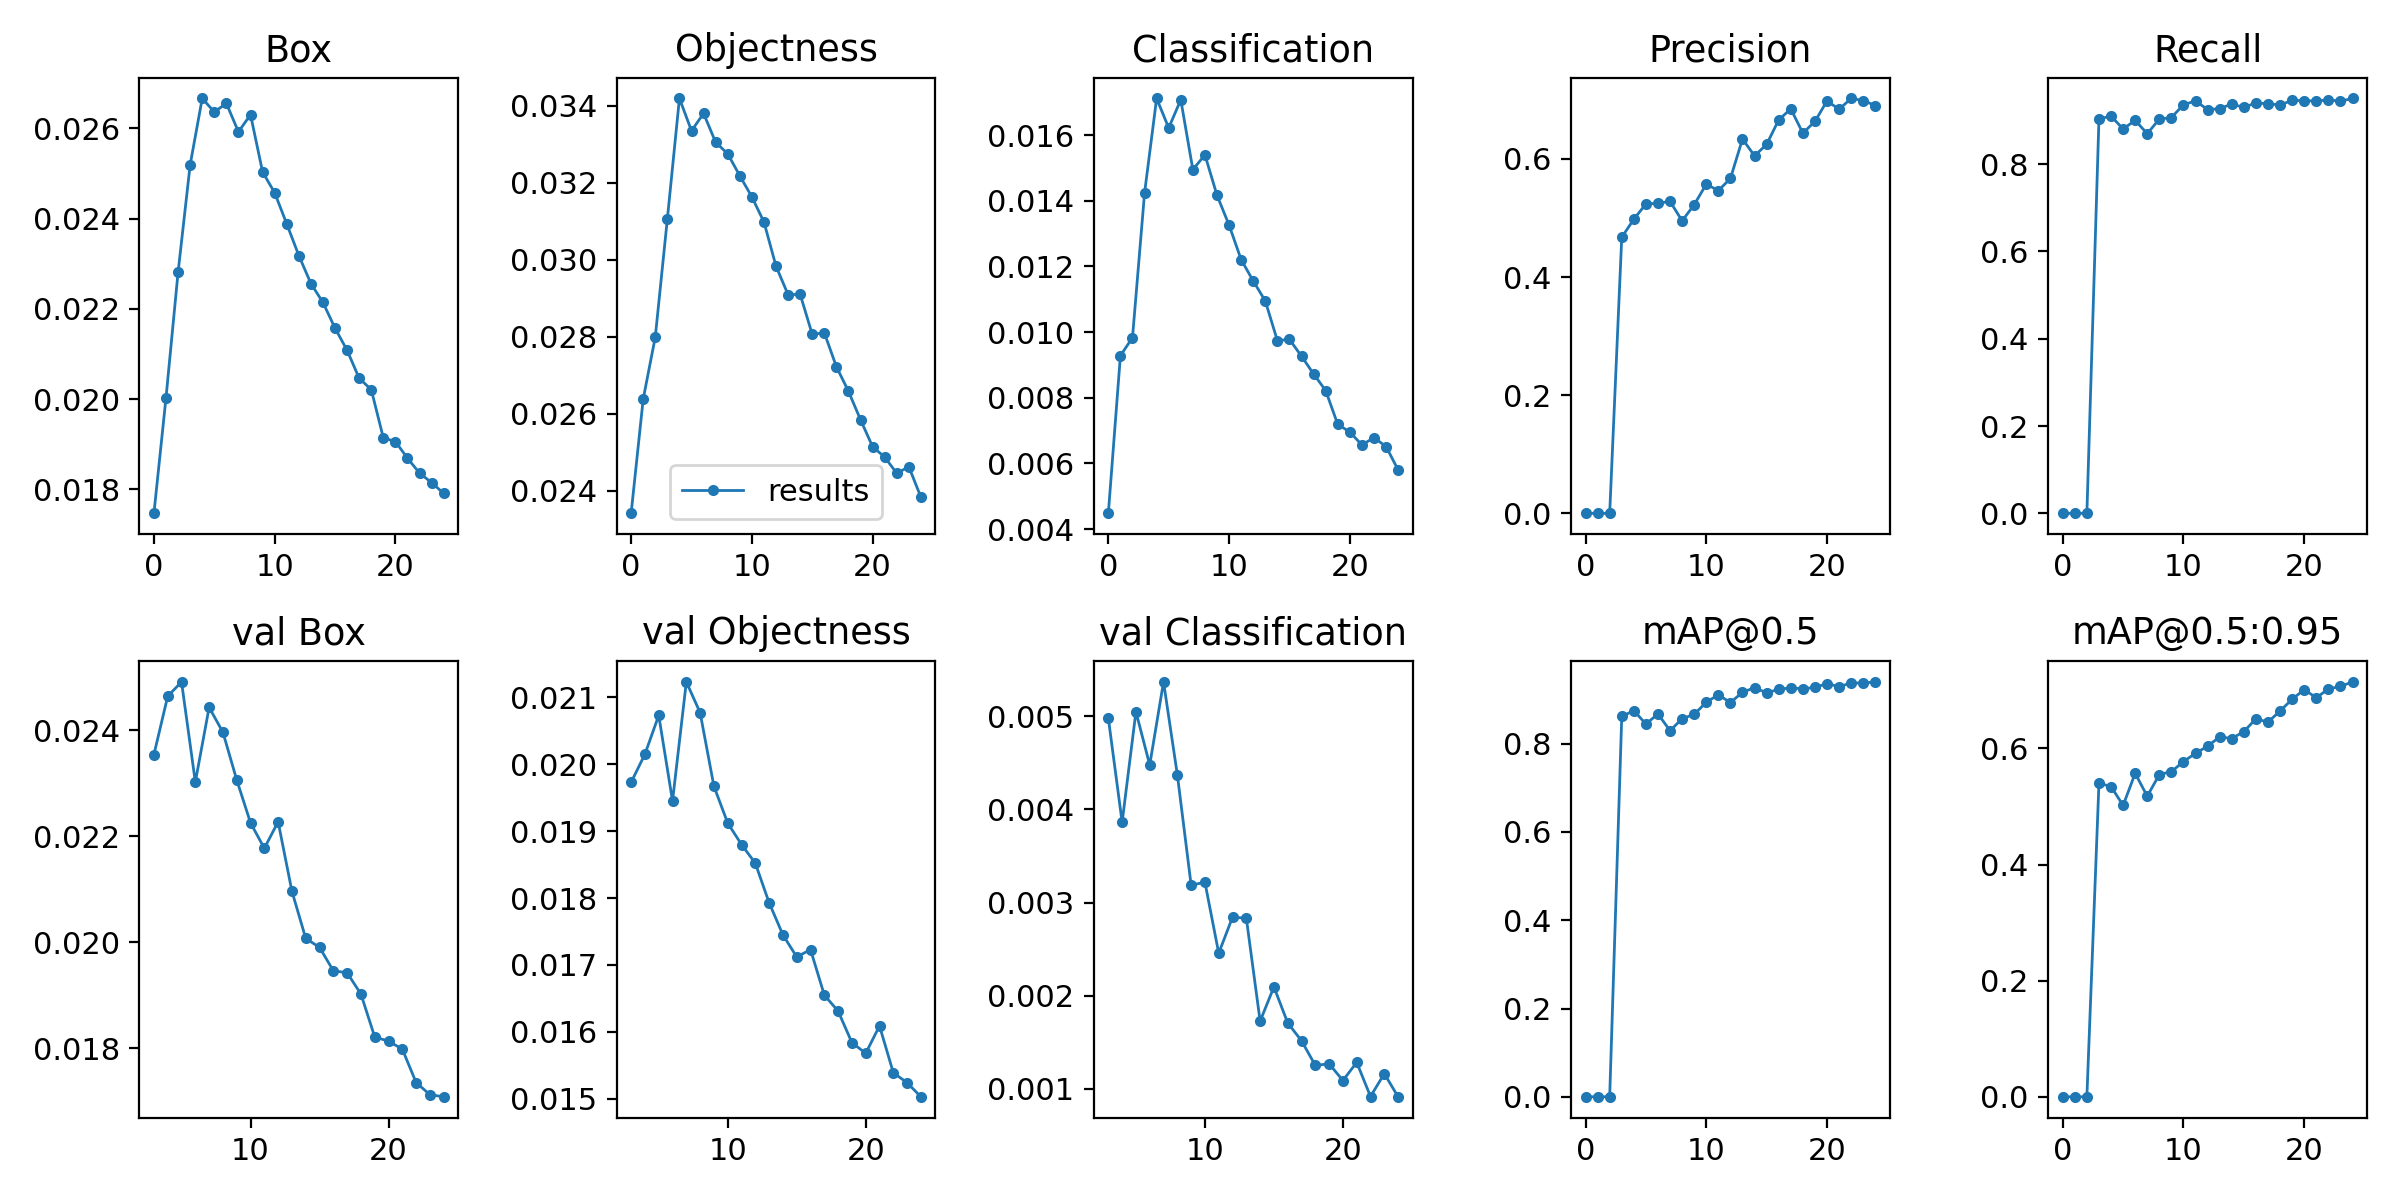

In [ ]:
from IPython.display import Image
# we can also output some older school graphs if the tensor board isn't working for whatever reason... 
from utils.plots import plot_results  # plot results.txt as results.png
filename = run_dir + 'results.png'
Image(filename=filename, width=1000) 

creating file for class names

In [ ]:
%%writefile ../data.names
Front-Windscreen-Damage
Headlight-Damage
Major-Rear-Bumper-Dent
Rear-windscreen-Damage
RunningBoard-Dent
Sidemirror-Damage
Signlight-Damage
Taillight-Damage
bonnet-dent
doorouter-dent
fender-dent
front-bumper-dent
medium-Bodypanel-Dent
pillar-dent
quaterpanel-dent
rear-bumper-dent
roof-dent

Overwriting ../data.names


Manual observation on unlabelled test set

In [ ]:
!python detect.py --weights "/content/drive/MyDrive/Colab Notebooks/models/runs/train/yolor_p6_v25/weights/best_overall.pt" --conf 0.5 \
--img-size 640 \
--conf-thres 0.5 \
--iou-thres 0.65 \
--names ../data.names \
--source "/content/drive/MyDrive/Colab Notebooks/datasets/test/" \
--cfg cfg/yolor_p6_care_dent.cfg

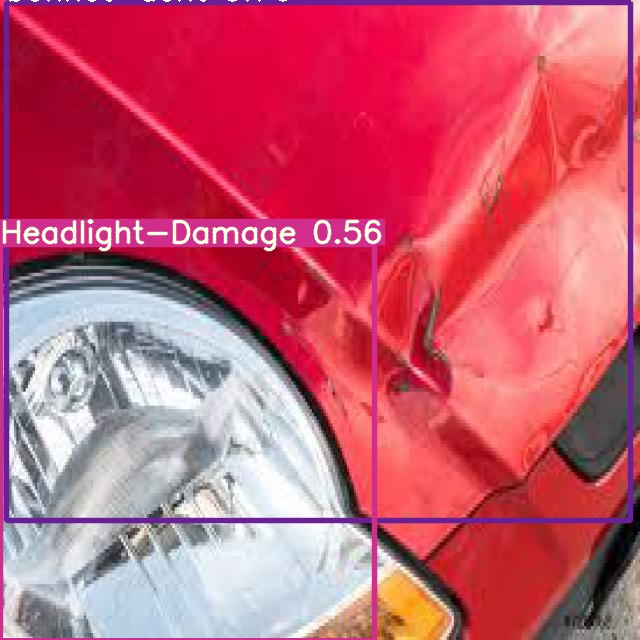

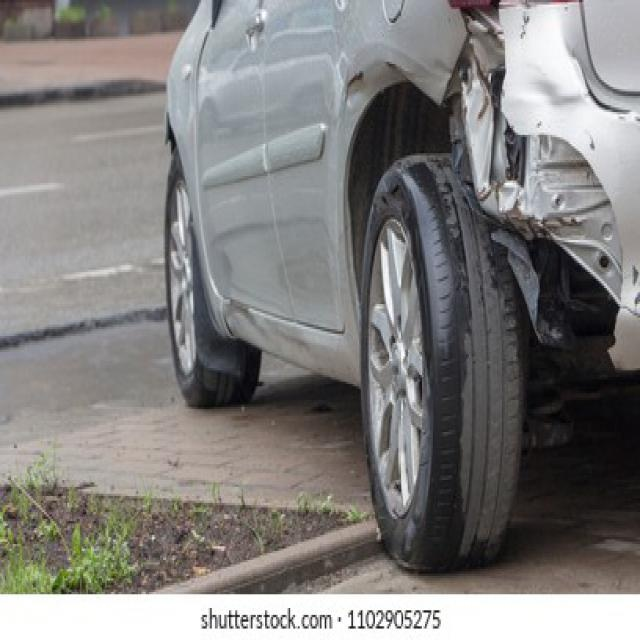

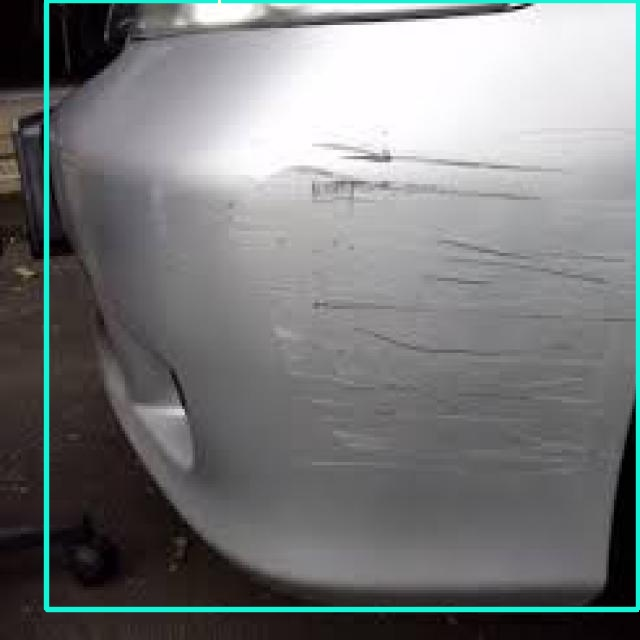

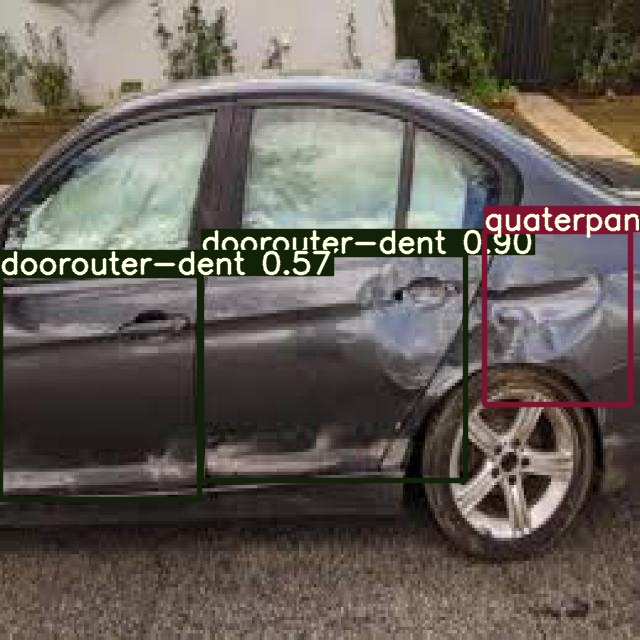

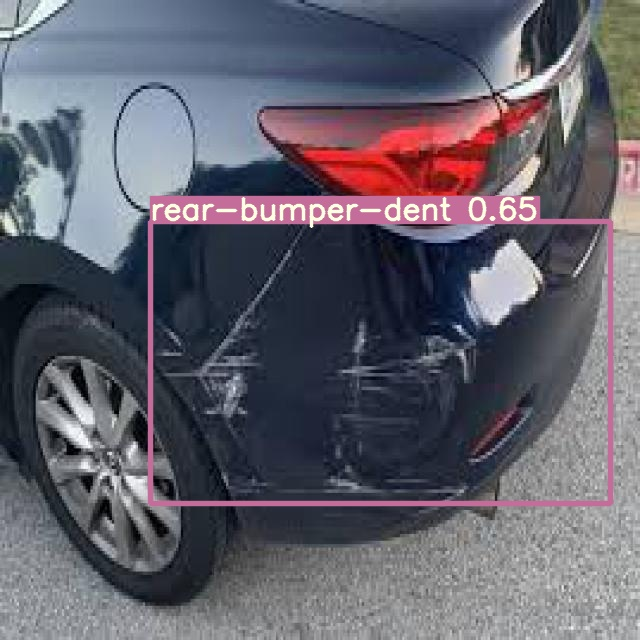

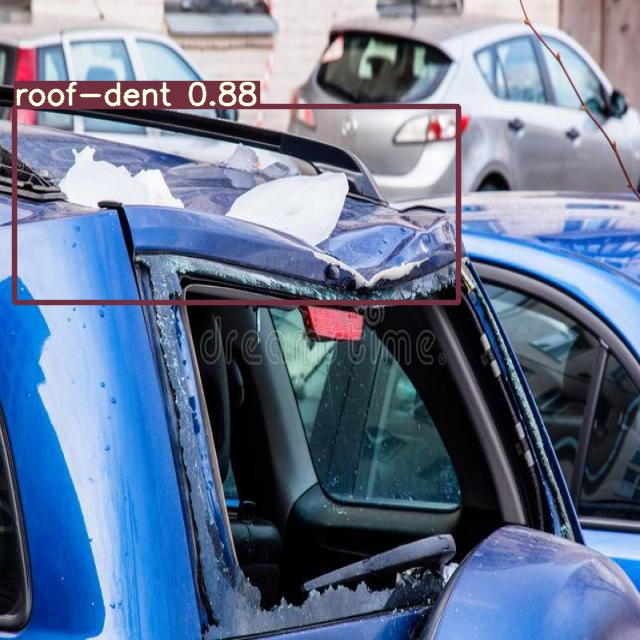

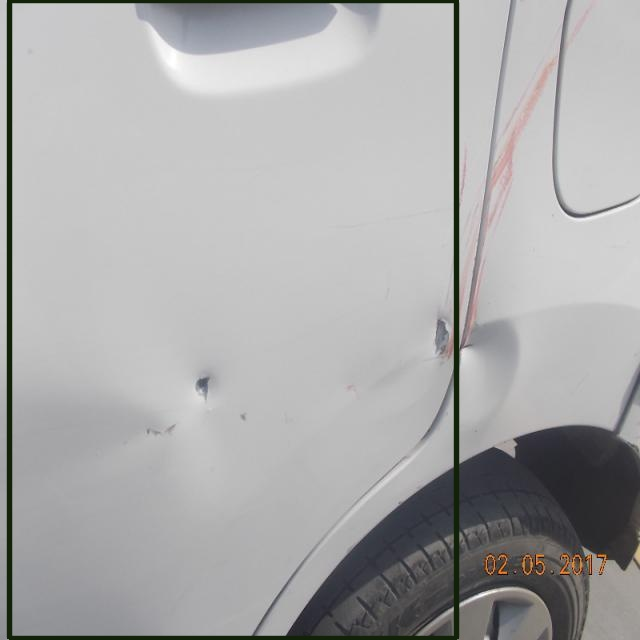

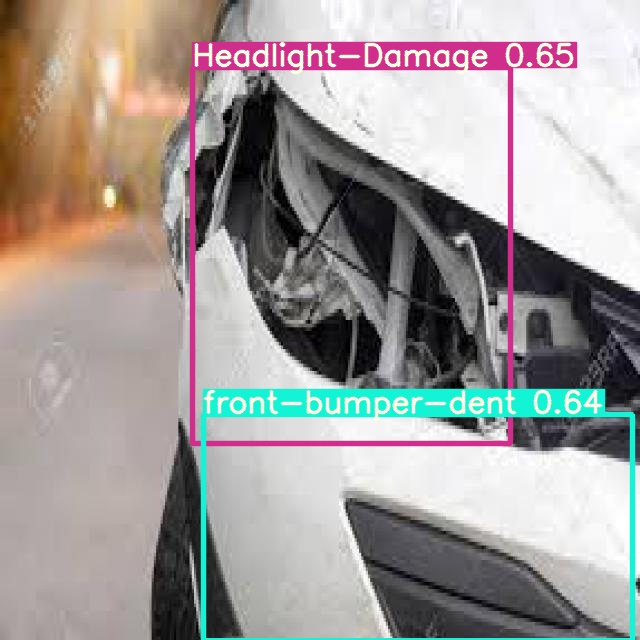

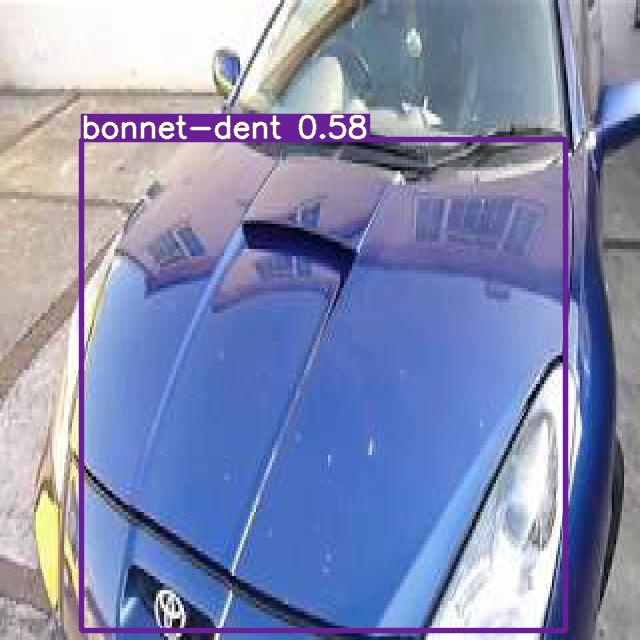

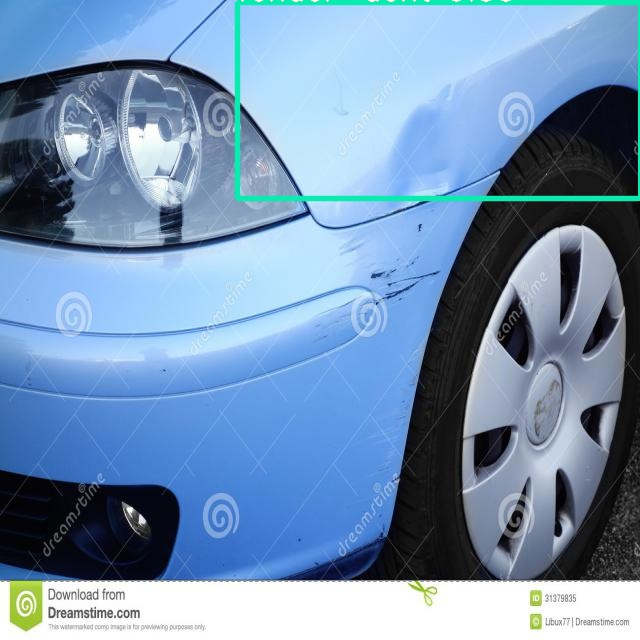

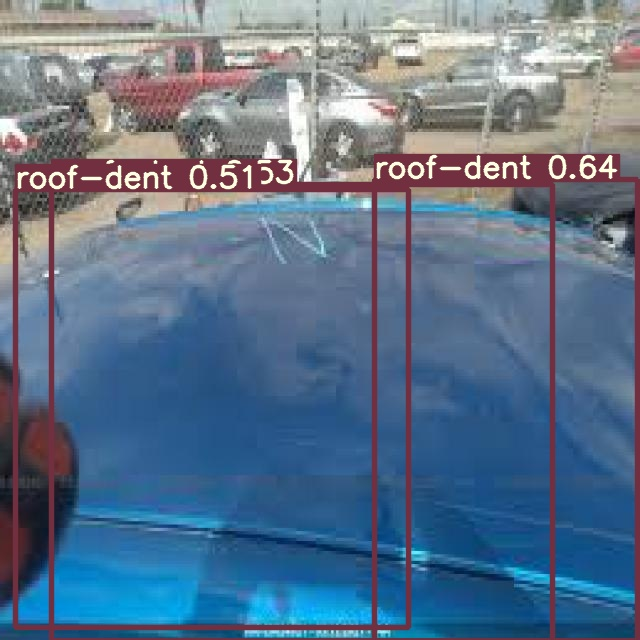

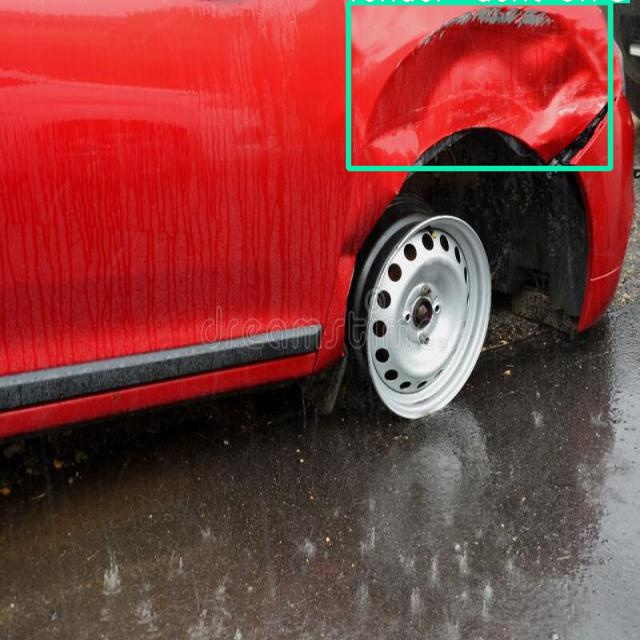

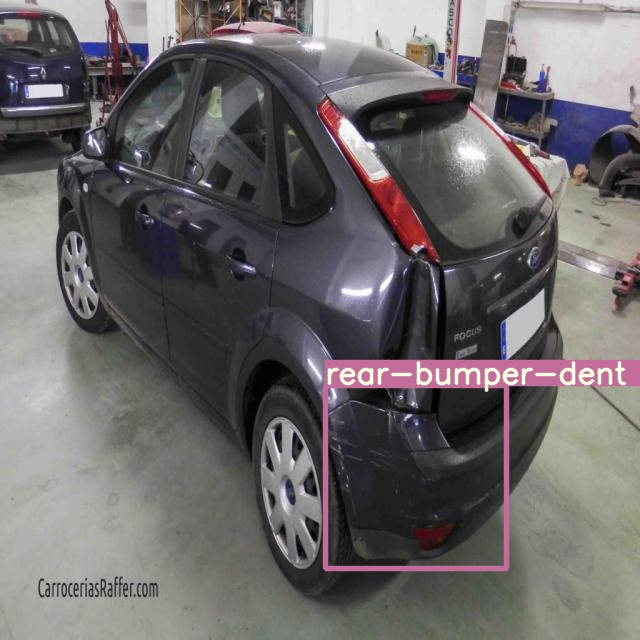

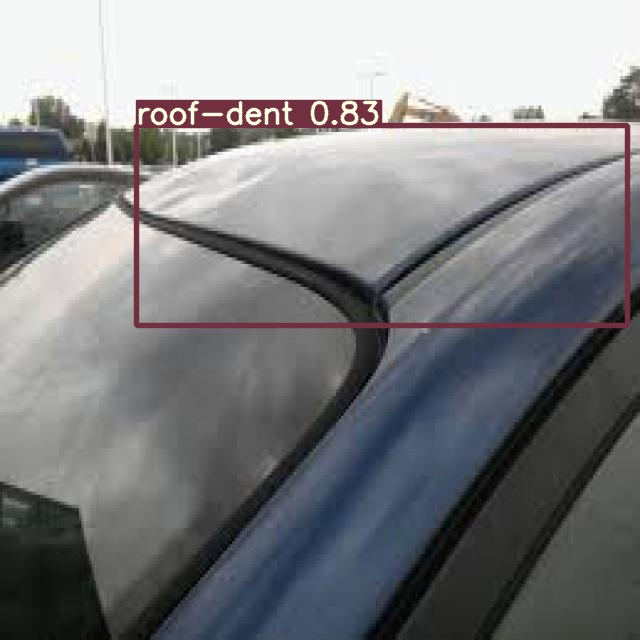

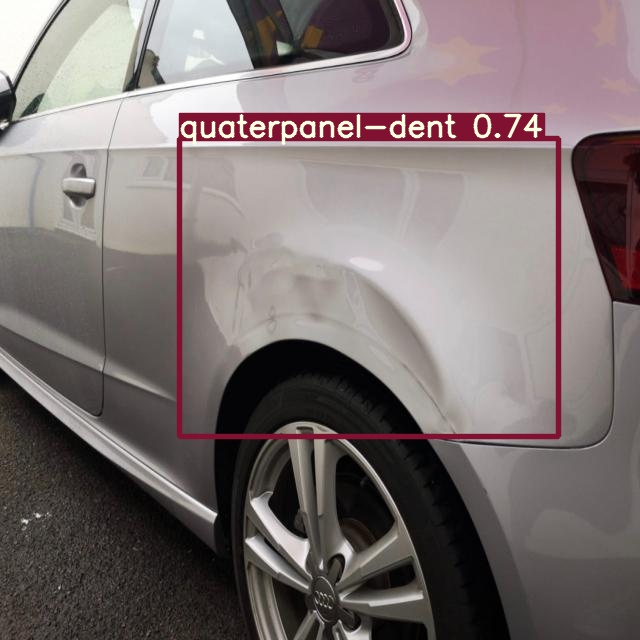

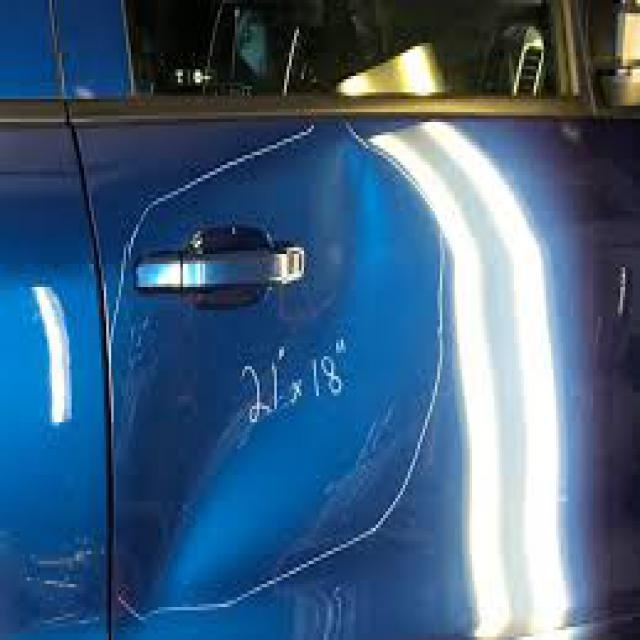

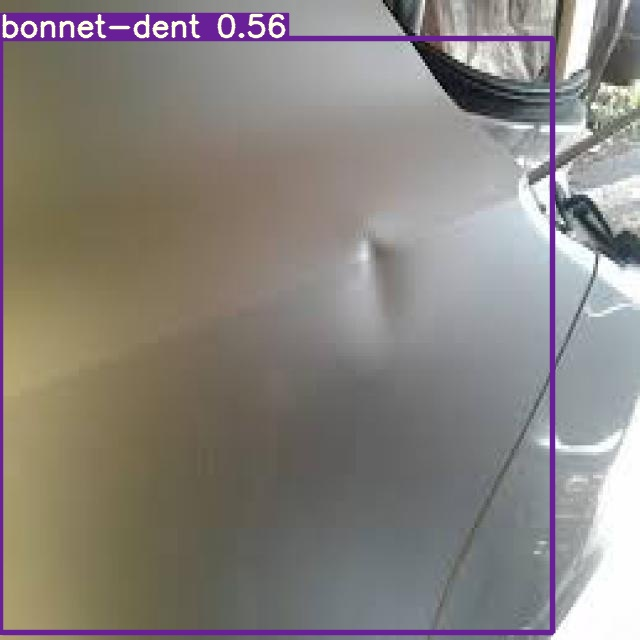

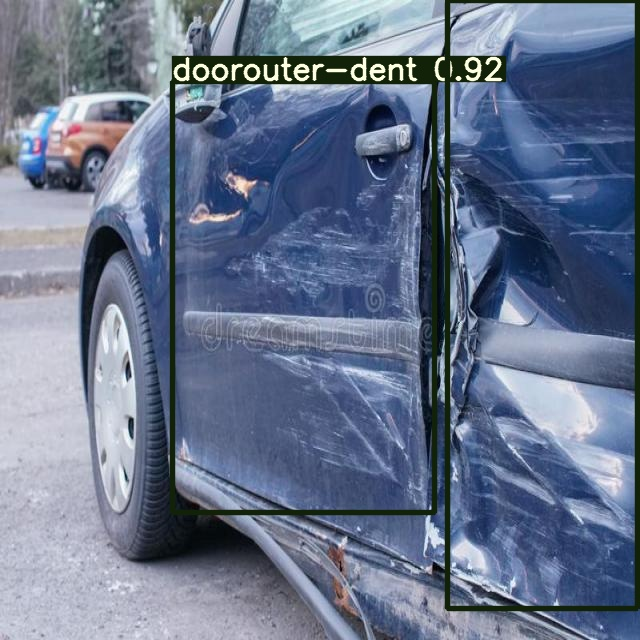

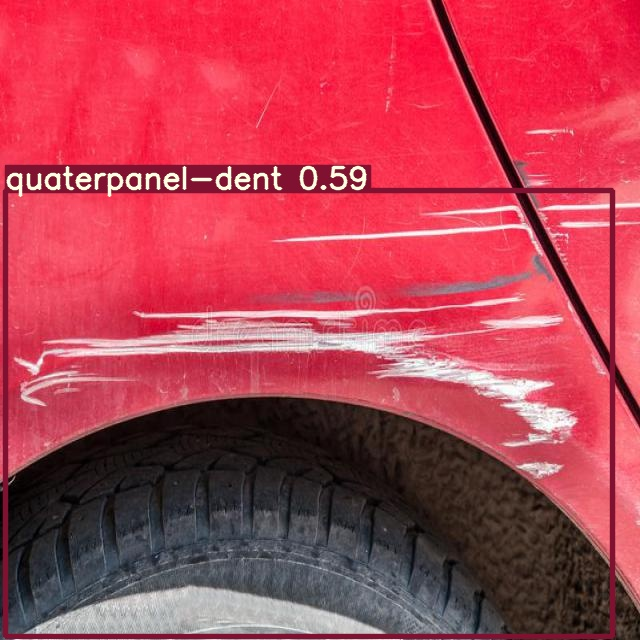

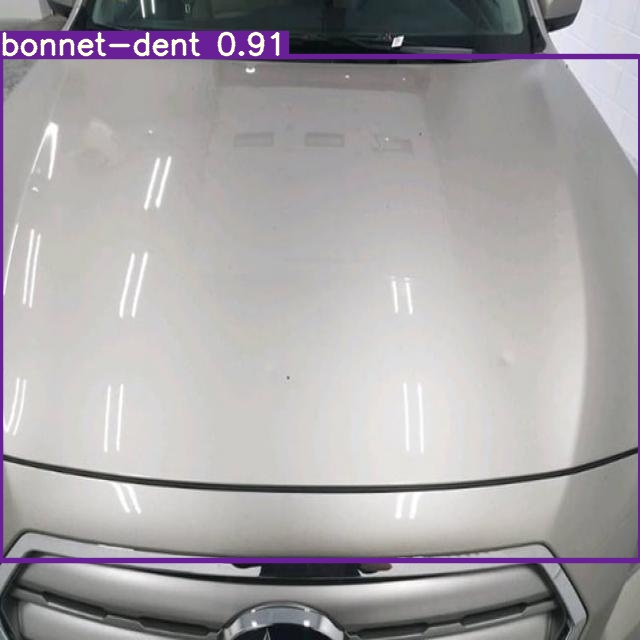

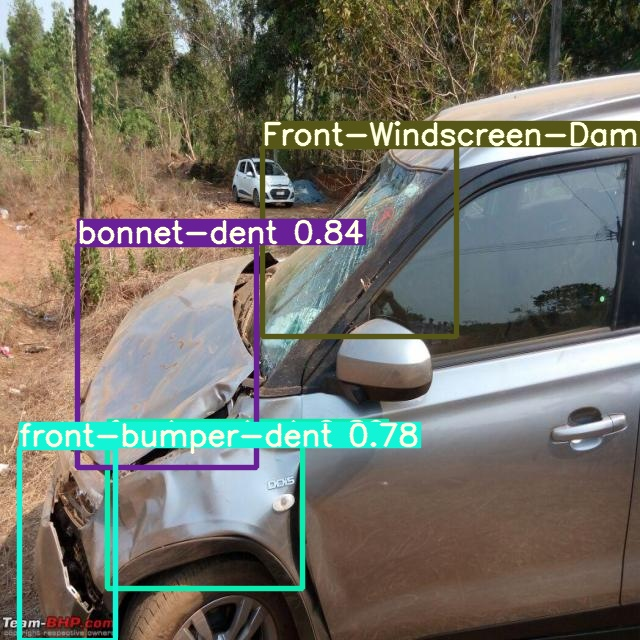

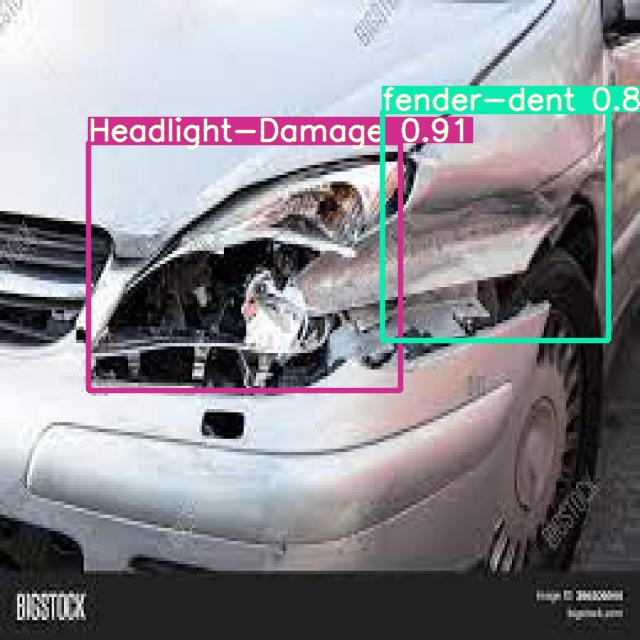

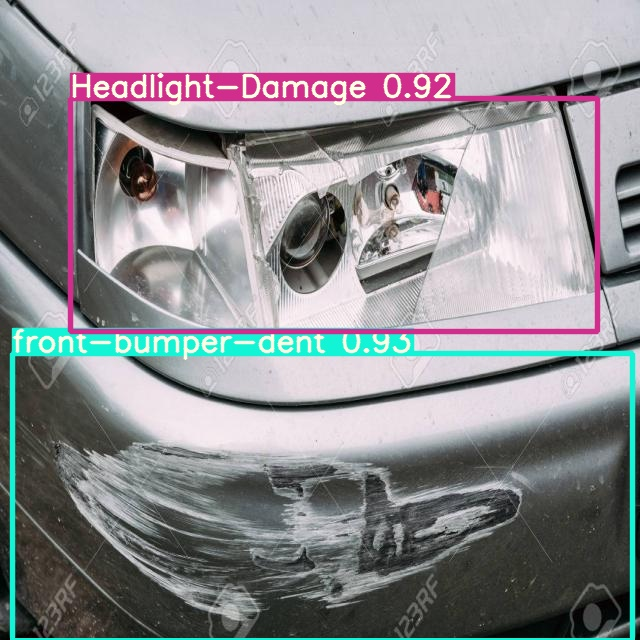

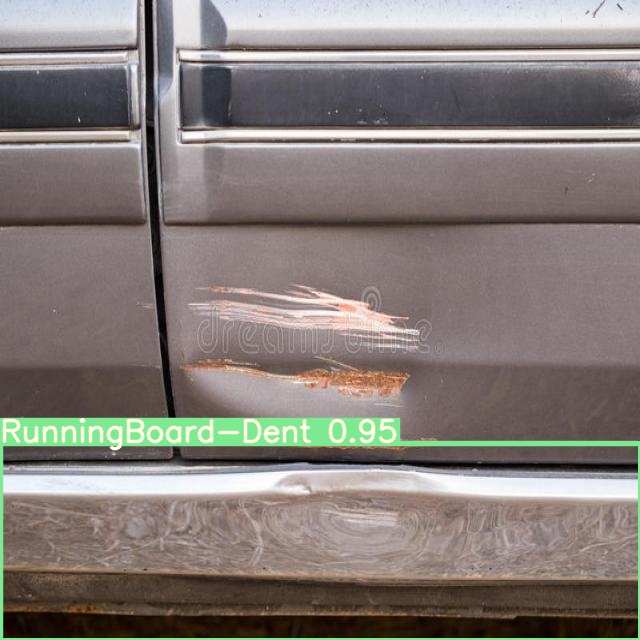

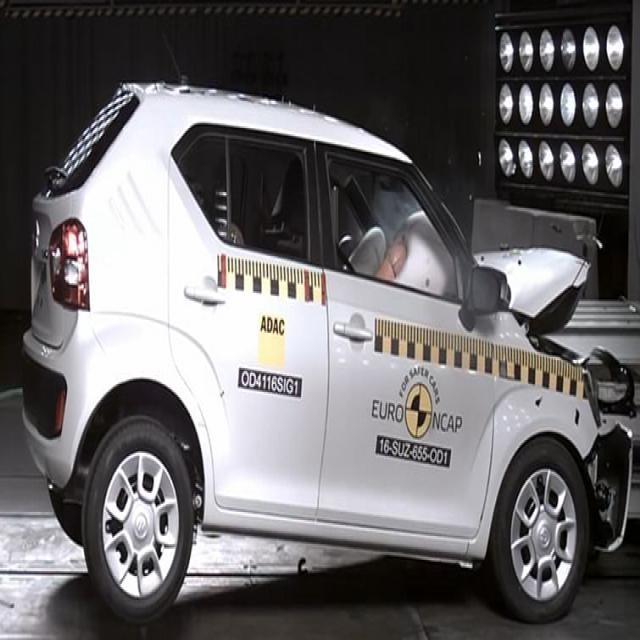

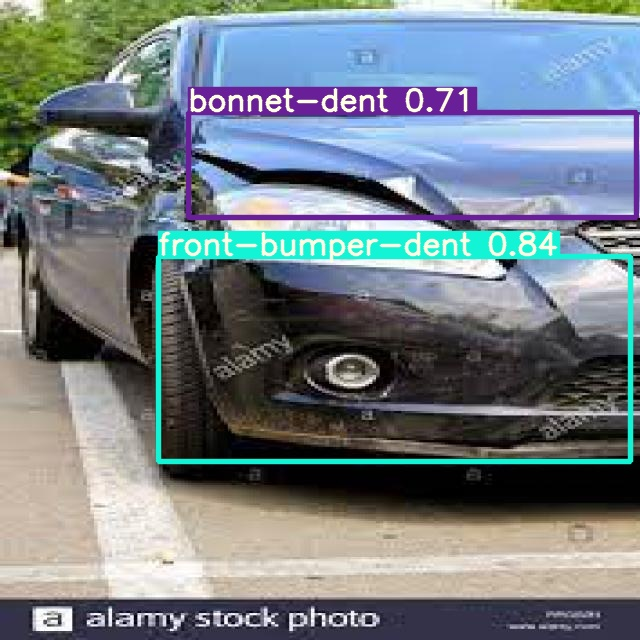

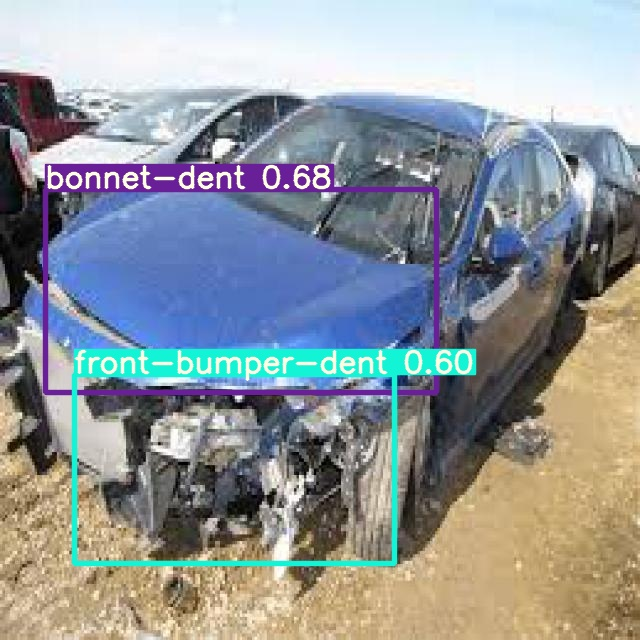

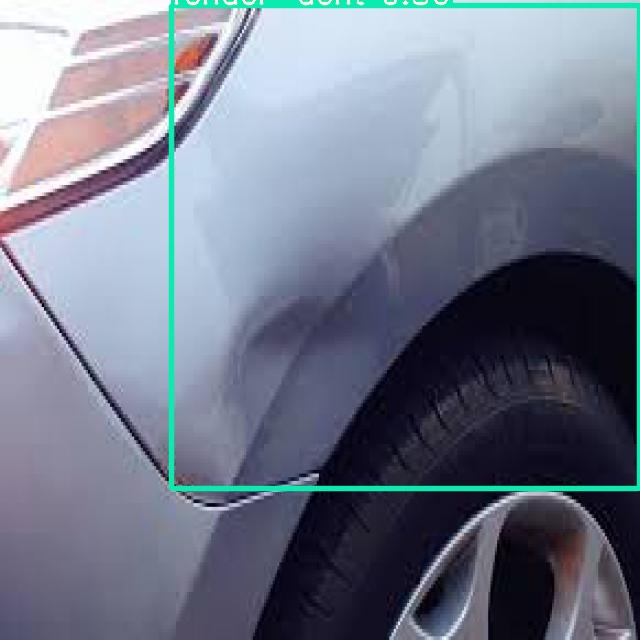

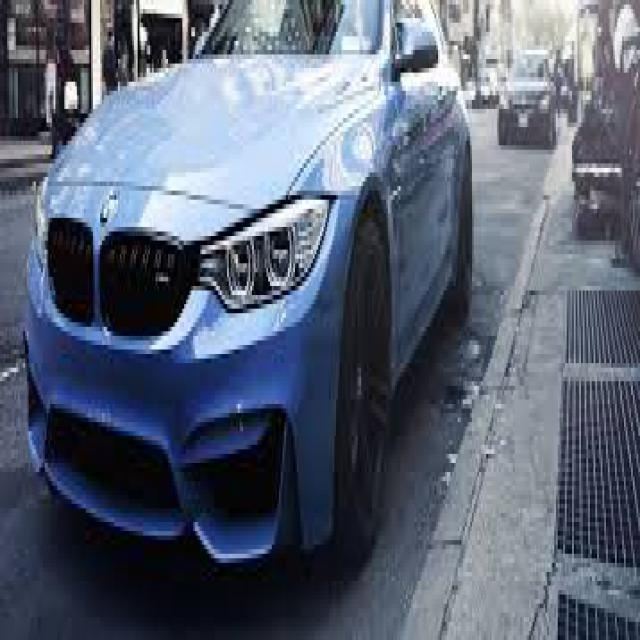

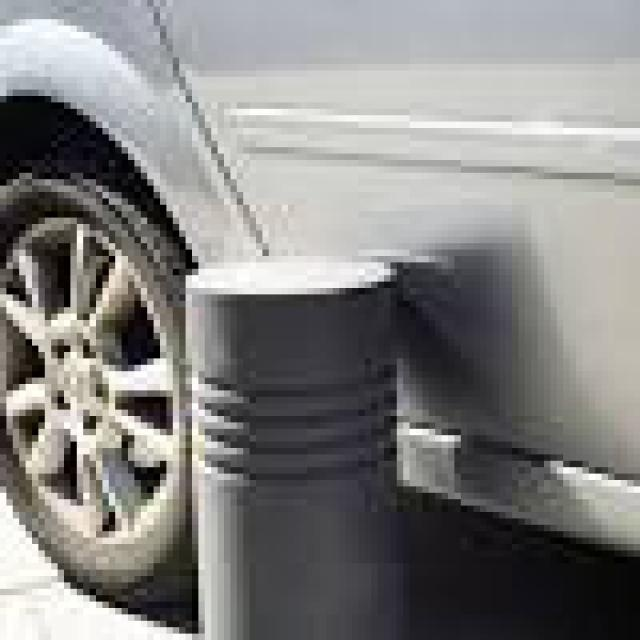

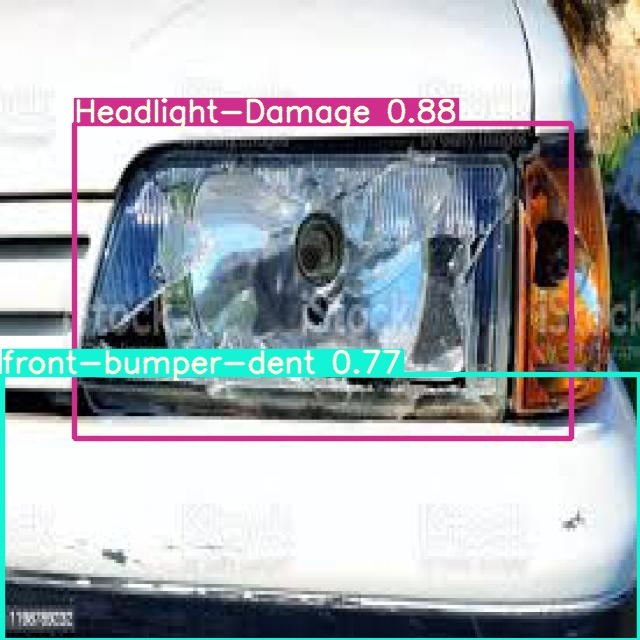

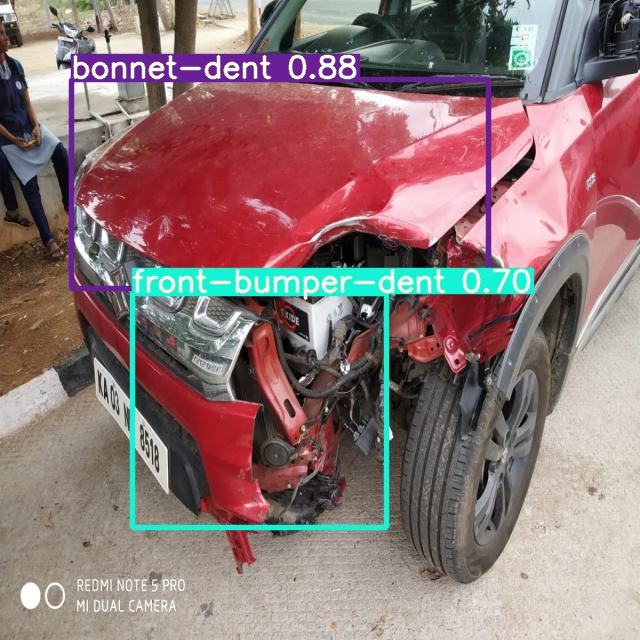

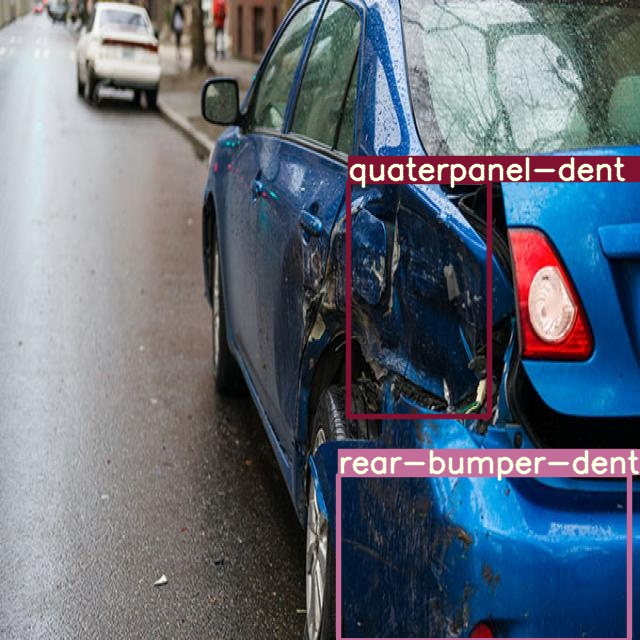

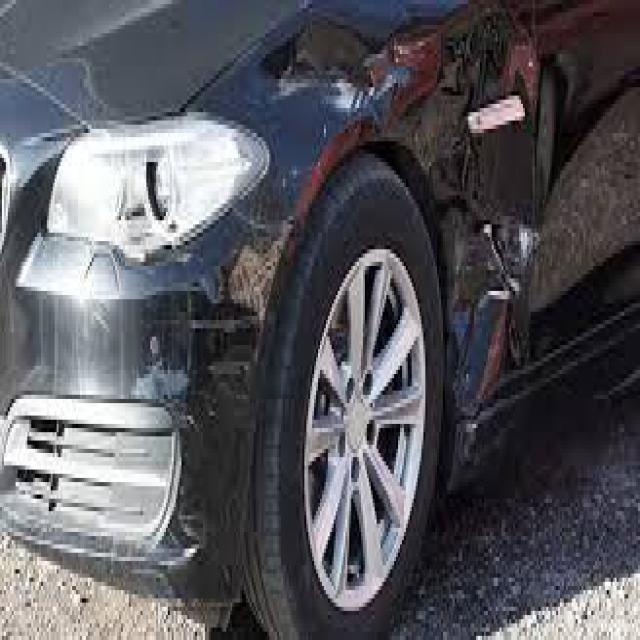

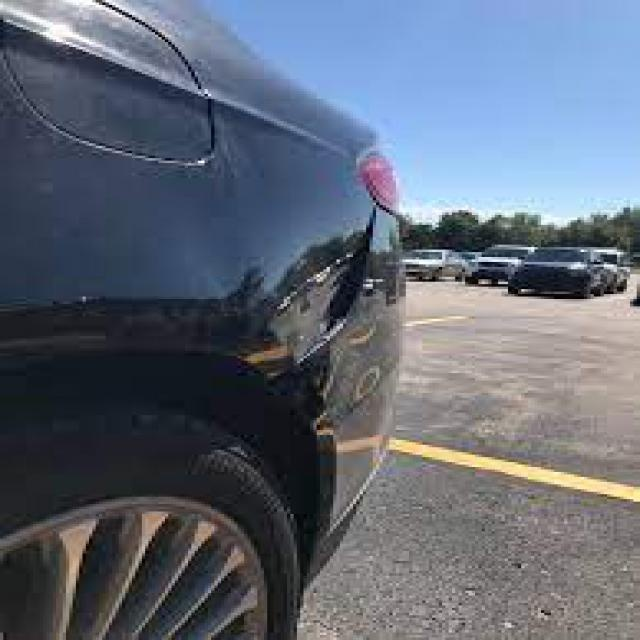

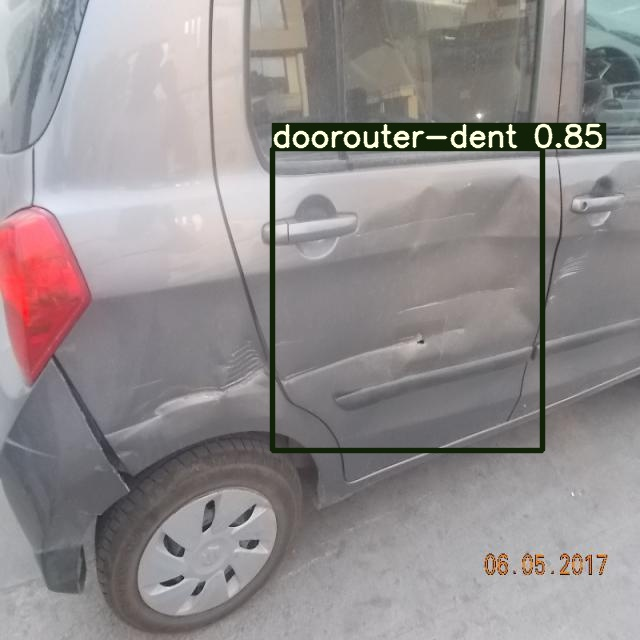

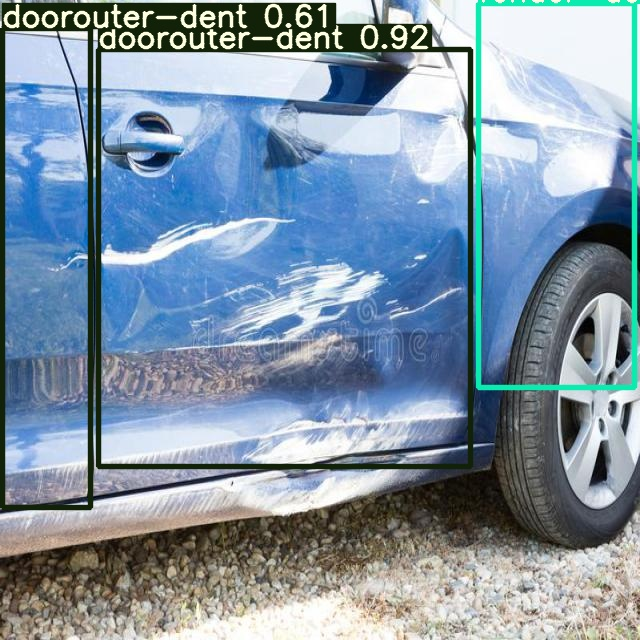

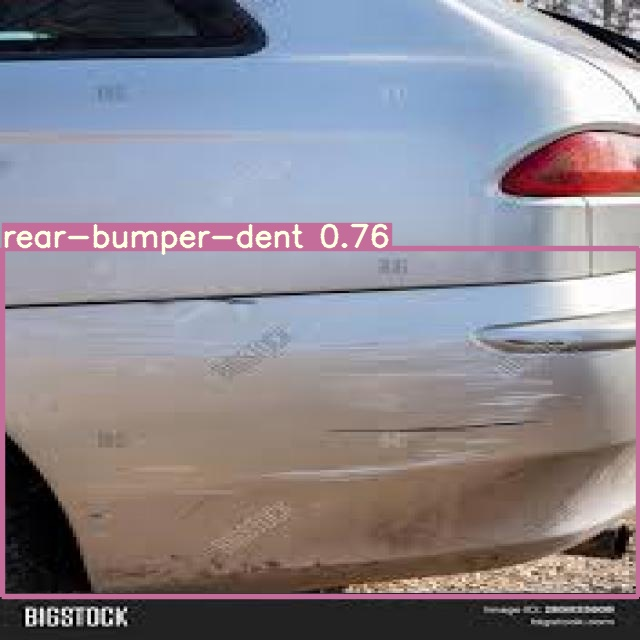

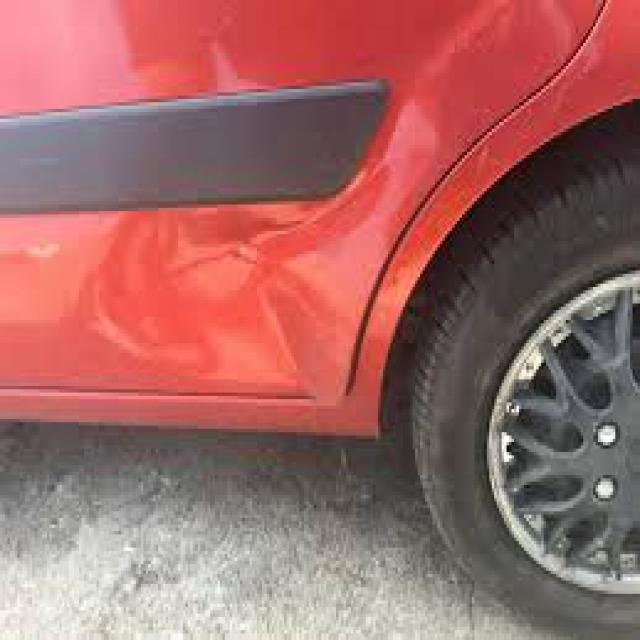

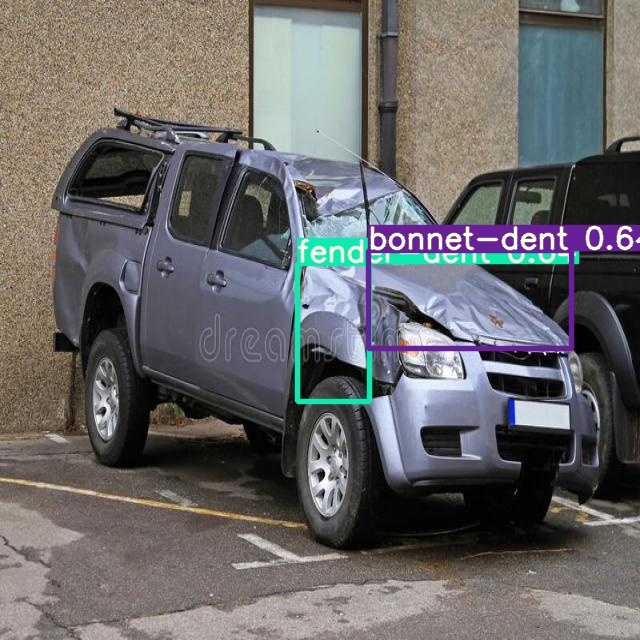

In [ ]:
import glob
from IPython.display import Image, display

for imageName in glob.glob('/content/yolor/inference/output/*.jpg')[:40]: #assuming JPG
    display(Image(filename=imageName))
    print("\n")

In [ ]:
!rm -r /content/yolor/inference/output

In [ ]:
!pwd

/content/yolor


In [ ]:
!python test.py --data ../data.yaml \
--names ../data.names \
--img 640 --batch 32 --conf 0.5 --iou 0.65 --device 0 \
--cfg cfg/yolor_p6_care_dent.cfg \
--weights "/content/drive/MyDrive/Colab Notebooks/models/runs/train/yolor_p6_v25/weights/best_overall.pt" \
--name yolor_p6_valid --task val

Namespace(augment=False, batch_size=32, cfg='cfg/yolor_p6_care_dent.cfg', conf_thres=0.5, data='../data.yaml', device='0', exist_ok=False, img_size=640, iou_thres=0.65, name='yolor_p6_valid', names='../data.names', project='runs/test', save_conf=False, save_json=False, save_txt=False, single_cls=False, task='val', verbose=False, weights=['/content/drive/MyDrive/Colab Notebooks/models/runs/train/yolor_p6_v25/weights/best_overall.pt'])
Using torch 1.7.0 CUDA:0 (Tesla K80, 11441MB)

Model Summary: 665 layers, 36924816 parameters, 36924816 gradients, 80.607662800 GFLOPS
Scanning labels ../valid/labels.cache3 (558 found, 0 missing, 0 empty, 0 duplicate, for 558 images): 558it [00:00, 9259.97it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100% 18/18 [00:42<00:00,  2.34s/it]
                 all         558         811       0.946       0.877       0.929       0.733
Speed: 65.3/2.1/67.4 ms inference/NMS/total per 640x640 image at batch-size 

In [ ]:
!python test.py --data ../data.yaml \
--names ../data.names \
--img 640 --batch 32 --conf 0.001 --iou 0.65 --device 0 \
--cfg cfg/yolor_p6_care_dent.cfg \
--weights "/content/drive/MyDrive/Colab Notebooks/models/runs/train/yolor_p6_v25/weights/best_overall.pt" \
--name yolor_p6_test --task test

Namespace(augment=False, batch_size=32, cfg='cfg/yolor_p6_care_dent.cfg', conf_thres=0.001, data='../data.yaml', device='0', exist_ok=False, img_size=640, iou_thres=0.65, name='yolor_p6_test', names='../data.names', project='runs/test', save_conf=False, save_json=False, save_txt=False, single_cls=False, task='test', verbose=False, weights=['/content/drive/MyDrive/Colab Notebooks/models/runs/train/yolor_p6_v25/weights/best_overall.pt'])
Using torch 1.7.0 CUDA:0 (Tesla K80, 11441MB)

Model Summary: 665 layers, 36924816 parameters, 36924816 gradients, 80.607662800 GFLOPS
Scanning labels ../test/labels.cache3 (577 found, 0 missing, 0 empty, 0 duplicate, for 577 images): 577it [00:00, 9813.37it/s]
               Class      Images     Targets           P           R      mAP@.5  mAP@.5:.95: 100% 19/19 [00:44<00:00,  2.34s/it]
                 all         577         805       0.729       0.961       0.954       0.724
Speed: 65.5/2.2/67.7 ms inference/NMS/total per 640x640 image at batch-size

In [ ]:
!rm -r /content/yolor/runs/test